# PostNord Trustpilot Reviews

## Structure of the code

1. Combine header and text column
2. Anonymisation
    - Remove names
    - Remove dates
    - Create unique ids for each person
    - Use review and url to remove repeated comments
    - Remove urls
3. Cleaning and processing
    - If a comment was only punctuation => remove that row
4. Balance data (around 17,000 per category)
    - Randomise data (in categories)
    - Keep the first 17,000 of each category

## Initial code

In [1]:
#!pip install -U spacy
#!python -m spacy download da_core_news_md
#!pip install nltk tensorflow numpy pandas seaborn scikit-learn scipy 

In [2]:
# system tools
import os
import sys
import random
#import spacy
#import da_core_news_md
import requests as req
from io import StringIO
import re

# data wranling
import pandas as pd
import numpy as np
from scipy.stats import randint

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [3]:
# define path
path = os.path.join("..", "in", "balanced_dataset.csv")

In [9]:
# read csv
df = pd.read_csv(path)
# make sure ratings are parsed as strings and not integers
df['rating'] = df['rating'].astype(str)

In [10]:
# create a new column 'category_id' with encoded categories 
df['category_id'] = df['rating'].factorize()[0]
# remove duplicates
category_id_df = df[['rating', 'category_id']].drop_duplicates()
# create dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'rating']].values)

## Vectorisation

### TD-IDF

In [13]:
# vectorise the texts
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df= 5, # exclude tokens that occurred in less than 5 texts
                        max_df = 95, # exclude tokens than ocurred in less than
                        ngram_range=(1, 2), # change to (1,3) to include trigrams
                        encoding = 'utf-16',
                        max_features = None)
# We transform each complaint into a vector
features = tfidf.fit_transform(df.review).toarray()
# get labels
labels = df.category_id
print("Each of the %d reviews is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 79455 reviews is represented by 21654 features (TF-IDF score of unigrams and bigrams)


In [14]:
# find the three most correlated terms with each of the ratings
N = 3
for rating, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    # if we wanted to include trigrams
    #trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    print("n==> %s:" %(rating))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))
    #if we wanted to include trigrams
    #print("  * Most Correlated Bigrams are: %s" %(', '.join(trigrams[-N:])))

n==> 1:
  * Most Correlated Unigrams are: skod, elendige, elendigt
  * Most Correlated Bigrams are: dårlig kundeservice, dårligste service, utrolig dårlig
n==> 2:
  * Most Correlated Unigrams are: alternativt, huller, angiveligt
  * Most Correlated Bigrams are: vælger pakkeboks, dage sent, forkert leveringssted
n==> 3:
  * Most Correlated Unigrams are: nogenlunde, blandet, middel
  * Most Correlated Bigrams are: irriterende pakken, levering irriterende, pakken trykket
n==> 4:
  * Most Correlated Unigrams are: stabil, pakkeforsendelse, uproblematisk
  * Most Correlated Bigrams are: udmærket service, rimelig hurtig, fin behandling
n==> 5:
  * Most Correlated Unigrams are: problemfrit, lyn, lynhurtigt
  * Most Correlated Bigrams are: hurtig problemfri, fantastisk hurtig, perfekt hurtig


## Finding the best classifier

In [15]:
X = df['review'] # collection of documents
y = df['rating'] # labels we want to predict (i.e., the 5 different ratings)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 42)

In [16]:
# list of models we want to test
models = [
    LinearSVC(), # should I try other SVC models?
    MultinomialNB(),
    ComplementNB(),
    LogisticRegression(random_state=42, max_iter = (y_train.value_counts().max() * 5)),
]

In [20]:
# cross-validation of 3
CV = 3 # the number of subsets into which the dataset is divided during cross-validation
cv_df = pd.DataFrame(index=range(CV * len(models)))

In [22]:
model_names = ["Linear Support Vector Classification", "Multinomial Naive Bayes", "Complement Naive Bayes", "Logistic Regression"]

In [23]:
entries = []
counter = 0
for model in models:
    title = model_names[counter]
    print(f"Training {title}...")
    counter += 1
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, accuracy))
    print(f"Training for {title} complete!\n")
cv_df = pd.DataFrame(entries, columns=['model_name', 'accuracy'])

Training Linear Support Vector Classification...
Training for Linear Support Vector Classification complete!

Training Multinomial Naive Bayes...
Training for Multinomial Naive Bayes complete!

Training Complement Naive Bayes...
Training for Complement Naive Bayes complete!

Training Logistic Regression...
Training for Logistic Regression complete!



In [24]:
cv_df.groupby(by = "model_name").mean()

,accuracy
model_name,
ComplementNB,0.367680
LinearSVC,0.396929
LogisticRegression,0.413844
MultinomialNB,0.370688


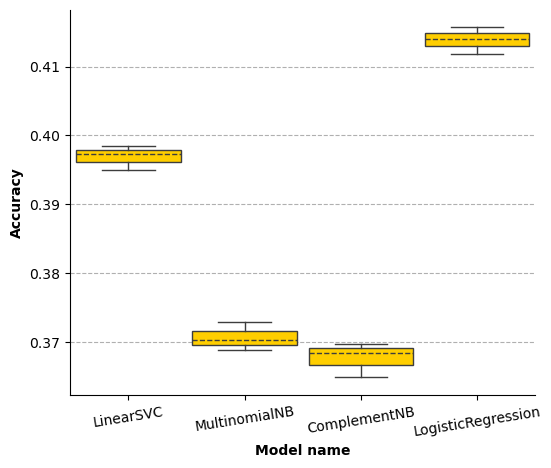

In [30]:
# place gridlines below elements in plots
plt.rc('axes', axisbelow=True)

# boxplot
fig, ax = plt.subplots(figsize=(6,5))

ax = sns.boxplot(x='model_name', y='accuracy', 
                 data=cv_df,
                 linewidth=1,
                 width = 0.9,
                 fliersize=5,
                 boxprops={"facecolor": "#ffce00"},
                 medianprops={"linewidth" : 1, "linestyle" : "--"})
plt.ylabel("Accuracy", fontsize = 10, weight = "bold")
plt.xlabel("Model name", fontsize = 10, weight = "bold")
plt.grid(axis = "y", linestyle = '--')
plt.xticks(rotation=9)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

## Training and testing the classifier

In [26]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df.index, test_size=0.25, 
                                                               random_state=42)
model = LogisticRegression(random_state=42, max_iter = (y_train.value_counts().max() * 5))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [28]:
# Classification report
print('CLASSIFICATION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df['rating'].unique()))

CLASSIFICATION METRICS

              precision    recall  f1-score   support

           1       0.47      0.48      0.47      3936
           2       0.34      0.32      0.33      3935
           3       0.36      0.30      0.33      4051
           4       0.38      0.26      0.31      4006
           5       0.47      0.72      0.57      3936

    accuracy                           0.42     19864
   macro avg       0.41      0.42      0.40     19864
weighted avg       0.40      0.42      0.40     19864



In [31]:
df['rating'].unique()

array(['1', '2', '3', '4', '5'], dtype=object)

In [56]:
from  matplotlib.colors import LinearSegmentedColormap
c = ["#edfbfe", "#aee0f5","#6bcae8","#2db3e0","#1b91b8","#166c8c","#0d4960"]
v = [0,.15,.4,.5,0.6,.9,1.]
l = list(zip(v,c))
cmap=LinearSegmentedColormap.from_list('rg',l, N=256)

Text(0.5, 25.722222222222214, 'Predicted')

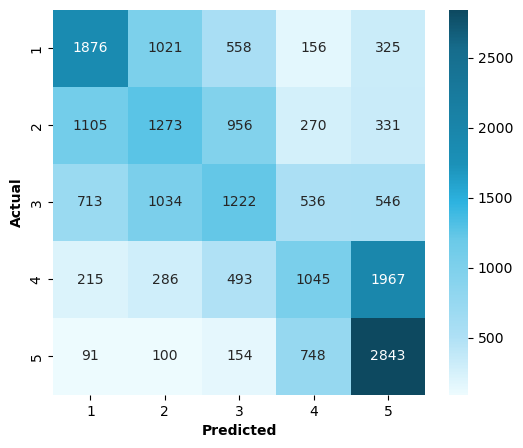

In [57]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, cmap = cmap, fmt='d',
            xticklabels=category_id_df.rating.values, 
            yticklabels=category_id_df.rating.values)
plt.ylabel('Actual', fontsize = 10, weight = "bold")
plt.xlabel('Predicted', fontsize = 10, weight = "bold")

## Prediction

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 42)

In [78]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df= 10, max_df = 90,
                        ngram_range=(1, 3), encoding = 'utf-16')
fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)
model = LogisticRegression(random_state=42, max_iter = (y_train.value_counts().max() * 5)).fit(tfidf_vectorizer_vectors, y_train)

In [79]:
# 2
rev = """Jeg fik aldrig besked om at pakken kunne hentes.
Kontakt til Postnord er særdeles utilfredsstillende. Kan ikke kontaktes på telefon. Ved chat oplevede jeg to gange ca. 75 min ventetid, og de fik ikke løst problemet.
Jeg endte med at kontakte Shell tanken for at høre om de måtte have pakken liggende. Og det havde de, den var bare ikke blevet registreret. Jeg hentede derefter pakken.
Mvh Claus"""

print(model.predict(fitted_vectorizer.transform([rev])))

['1']


In [80]:
# 5
rev = """Jeg fik en sms om at min pakke var afleveret i postkassen, men der var ingen pakke der. Prøvede så at ringe til post nord, det er bare så ringe at komme igennem til jer. Så tog jeg fat i vores søde post dame, og så fiskede hun lige sagen og jeg fik pakken et par dage efter. 💪"""

print(model.predict(fitted_vectorizer.transform([rev])))

['1']


In [81]:
# 5
rev = """JEG FANDT MIN PAKKE I MIT SKUR DET VAR DEJLIGT SÅ SKULLE JEG IKKE HENTE DEN ET ANDET STED DET VAR JEG GLAD FOR MEN HAR IKKE PAKKET DEN UD ENDNU DA JEG SKAL HAVE HJÆLP TIL AT FÅ DEN TILSLUTTET TAK MED VENLIG HILSEN SONJA KNUDSEN ÅBYBRO."""

print(model.predict(fitted_vectorizer.transform([rev])))

['4']


In [82]:
# 3
rev = """Altid hurtig, men jeg tror ikke buddene forstår Modtager Flex. Jeg er tilmeldt, men sidst ringede buddet fordi jeg ikke var hjemme (heldigvis, så jeg kunne sige at jeg var tilmeldt det og at han kunne sætte pakken) 
Næste gang tog buddet et billede af pakken ved døren, men har så taget den med igen, hvilket bare gav forvirring for mig om hvorvidt den var blevet sat der eller ej.

Af en eller anden grund bliver pakkerne også oftest lagt i en pakkeshop over 3 km væk, selvom der er mere end en pakkeshop tættere på. Det er virkelig irriterende, især når pakken i første omgang bare skulle have været sat ved døren"""

print(model.predict(fitted_vectorizer.transform([rev])))

['3']


## Machine

In [83]:
X = df["review"]
y = df["rating"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
y_train.value_counts()

1    12762
2    12757
5    12733
3    12659
4    12653
Name: rating, dtype: int64

In [84]:
y_train.value_counts().max()

12762

In [85]:
vectorizer = CountVectorizer(ngram_range = (1,3), 
                             lowercase = False,
                             max_df = 0.99,  
                             min_df = 0.01,
                             max_features = None,
                             encoding = 'utf-16')

X_train_feats = vectorizer.fit_transform(X_train)
X_test_feats = vectorizer.transform(X_test)

feature_names = vectorizer.get_feature_names_out()

In [86]:
classifier = LogisticRegression(random_state = 7, max_iter = (y_train.value_counts().max() * 5)).fit(X_train_feats, y_train)

In [88]:
y_pred = classifier.predict(X_test_feats)

classifier_metrics = metrics.classification_report(y_test, y_pred)
print(classifier_metrics)

              precision    recall  f1-score   support

           1       0.45      0.54      0.49      3129
           2       0.36      0.32      0.34      3134
           3       0.36      0.29      0.33      3232
           4       0.38      0.32      0.35      3238
           5       0.54      0.70      0.61      3158

    accuracy                           0.43     15891
   macro avg       0.42      0.43      0.42     15891
weighted avg       0.42      0.43      0.42     15891

